# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [185]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.tree import DecisionTreeClassifier

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [284]:

# using the SQLite Table to read data.
con = sqlite3.connect(r'C:\Sandy\privy\AI\Data Sets\Amazon Food rev dataset\database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

#Took 3000 points from each Category i.e from Positive reviews and Negative Reviews
#Negative Data
Neg_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score < 3 LIMIT 1000""", con) 
#Positive Data
Pos_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score > 3 LIMIT 1000""", con) 

Neg_data.head()
preprocessed_data =pd.concat([Neg_data,Pos_data])
print("Total Sample Points : ",preprocessed_data.shape)
#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)
print("\n Sample Points : ")
preprocessed_data.head()

Total Sample Points :  (2000, 10)

 Sample Points : 


Id   ProductId          UserId     ProfileName  HelpfulnessNumerator  \
0   2  B00813GRG4  A1D87F6ZCVE5NK          dll pa                     0   
1   4  B000UA0QIQ  A395BORC6FGVXV            Karl                     3   
2  13  B0009XLVG0   A327PCT23YH90              LT                     1   
3  17  B001GVISJM  A3KLWF6WQ5BNYO  Erica Neathery                     0   
4  27  B001GVISJM  A3RXAU2N8KV45G          lady21                     0   

   HelpfulnessDenominator  Score        Time  \
0                       0      1  1346976000   
1                       3      2  1307923200   
2                       1      1  1339545600   
3                       0      2  1348099200   
4                       1      1  1332633600   

                                Summary  \
0                     Not as Advertised   
1                        Cough Medicine   
2  My Cats Are Not Fans of the New Food   
3                            poor taste   
4                       Nasty No flavor   

                                                Text  
0  Product arrived labeled as Jumbo Salted Peanut...  
1  If you are looking for the secret ingredient i...  
2  My cats have been happily eating Felidae Plati...  
3  I love eating them and they are good for watch...  
4  The candy is just red , No flavor . Just  plan...

In [285]:
preprocessed_data=preprocessed_data[preprocessed_data['HelpfulnessNumerator']<=preprocessed_data['HelpfulnessDenominator']]

In [286]:
preprocessed_data.shape

(2000, 10)

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [287]:
#Sorting data according to ProductId in ascending order
sorted_data=preprocessed_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [288]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = preprocessed_data['Score']
positiveNegative = actualScore.map(partition) 
preprocessed_data['Score'] = positiveNegative
print("Number of data points in our dataset", preprocessed_data.shape)
preprocessed_data.head(3)

Number of data points in our dataset (2000, 10)


Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   
1   4  B000UA0QIQ  A395BORC6FGVXV        Karl                     3   
2  13  B0009XLVG0   A327PCT23YH90          LT                     1   

   HelpfulnessDenominator  Score        Time  \
0                       0      0  1346976000   
1                       3      0  1307923200   
2                       1      0  1339545600   

                                Summary  \
0                     Not as Advertised   
1                        Cough Medicine   
2  My Cats Are Not Fans of the New Food   

                                                Text  
0  Product arrived labeled as Jumbo Salted Peanut...  
1  If you are looking for the secret ingredient i...  
2  My cats have been happily eating Felidae Plati...

In [289]:
#Deduplication of entries
final_data=preprocessed_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_data.shape



(1991, 10)

In [290]:
#Checking to see how much % of data still remains

(final_data['Id'].size*1.0)/(preprocessed_data['Id'].size*1.0)*100

99.55000000000001

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [291]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [292]:
final=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [293]:
final=final.sort_values('Time',axis=0, ascending=True , inplace=False, kind='quicksort', na_position='last' )


In [294]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
print(final['Score'].value_counts())


(1991, 10)
1    998
0    993
Name: Score, dtype: int64


In [295]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

y=final[['Score']]
print(len(y))



(1991, 10)
1991


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [296]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [297]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [298]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews_text = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_text.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 1991/1991 [00:01<00:00, 1705.59it/s]


In [299]:
preprocessed_reviews_text[1]

'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [300]:

from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 1991/1991 [00:01<00:00, 1806.11it/s]


<h2 style="background-color:#fffff">Concatenating Summary and text reviews</h2>

In [301]:
preprocessed_reviews=[]
for i in tqdm(range(len(preprocessed_reviews_text))):
    preprocessed_reviews.append(preprocessed_reviews_text[i]+' '+preprocessed_reviews_summary[i])


100%|██████████████████████████████████████████████████████████████████████████| 1991/1991 [00:00<00:00, 398437.87it/s]


In [302]:
preprocessed_reviews[0]

'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs great product'

In [303]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(preprocessed_reviews,y,test_size =0.3,shuffle=False,stratify=None)

In [304]:
print("train x shape",len(x_train))
print("Test x Shape  ",len(x_test),"\n")
print(y_test['Score'].value_counts(),"\n")
print(y_train['Score'].value_counts(),"\n")
print("Train y  Shape  ",len(y_train),"\n")
print("Test Y  Shape  ",len(y_test))

train x shape 1393
Test x Shape   598 

0    324
1    274
Name: Score, dtype: int64 

1    724
0    669
Name: Score, dtype: int64 

Train y  Shape   1393 

Test Y  Shape   598


# [4] Featurization

## [4.1] BAG OF WORDS

In [306]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [305]:

#BoW
count_vect = CountVectorizer(ngram_range=(1,2),min_df=10,analyzer='word',max_features=5000) #in scikit-learn
count_vect.fit(x_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

x_train_BOW = count_vect.transform(x_train)
print("the type of count vectorizer ",type(x_train_BOW))
print("the shape of out text BOW vectorizer ",x_train_BOW.get_shape())
print("the number of unique words ", x_train_BOW.get_shape()[1])
print("=="*50)


x_test_BOW=count_vect.transform(x_test)
print("the type of count vectorizer ",type(x_test_BOW))
print("the shape of out text BOW vectorizer ",x_test_BOW.get_shape())
print("the number of unique words ", x_test_BOW.get_shape()[1])


some feature names  ['able', 'absolutely', 'acid', 'actual', 'actually', 'add', 'added', 'addicted', 'adding', 'addition']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (1393, 1090)
the number of unique words  1090
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (598, 1090)
the number of unique words  1090


## [4.2] TF-IDF

In [307]:
from sklearn.model_selection import train_test_split

x_train_tf_idf_sent,x_test_tf_idf_sent,y_train_tf_idf,y_test_tf_idf=train_test_split(preprocessed_reviews,y,test_size =0.3)

In [308]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10,analyzer='word',max_features=5000)
tf_idf_vect.fit(x_train_tf_idf_sent)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

x_train_tf_idf = tf_idf_vect.transform(x_train_tf_idf_sent)
print("the type of count vectorizer ",type(x_train_tf_idf))
print("the shape of out text TFIDF vectorizer ",x_train_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_train_tf_idf.get_shape()[1])
print('='*50)


x_test_tf_idf = tf_idf_vect.transform(x_test_tf_idf_sent)
print("the type of count vectorizer ",type(x_test_tf_idf))
print("the shape of out text TFIDF vectorizer ",x_test_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_test_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'acid', 'actual', 'actually', 'add', 'added', 'addicted', 'adding', 'addition']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (1393, 1070)
the number of unique words including both unigrams and bigrams  1070
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (598, 1070)
the number of unique words including both unigrams and bigrams  1070


# K-Means

## [5.1] Applying K-means  on BOW,<font color='red'> SET 1</font>

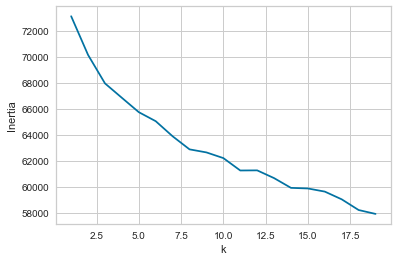

In [309]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


n_clusters=[i for i in range(1,20)]
#n_clusters=[1,2]
inertia=[]
#K-Means Model
for k in n_clusters:
    k_means_clstr=KMeans(n_clusters=k,init='k-means++')
    k_means_clstr.fit(x_train_BOW)
    inertia.append(k_means_clstr.inertia_)



plt.plot(n_clusters,inertia,label='K vs Inertia')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()



In [310]:
opt_k_BOW=7
k_means_bow=KMeans(n_clusters=opt_k_BOW,init='k-means++')
k_means_bow.fit(x_train_BOW)
#print(k_means_bow.labels_)

#print(cluster_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<h4>WordCloud per cluster</h4>

In [311]:
cluster_data={}
for i in range(0,opt_k_BOW):    
    cluster_data['clust{0}'.format(i)]=[]
#print(cluster_data)
#Words extraction per cluster
for i in range(0,len(k_means_bow.labels_)):        
    features=np.take(count_vect.get_feature_names(),x_train_BOW[i].indices).tolist()
    cluster_data['clust{0}'.format(k_means_bow.labels_[i])] =  cluster_data['clust{0}'.format(k_means_bow.labels_[i])]+features


WordCloud for Cluster : clust0  


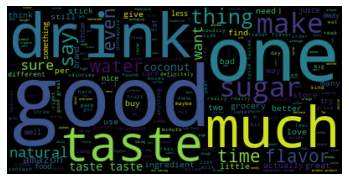

WordCloud for Cluster : clust1  


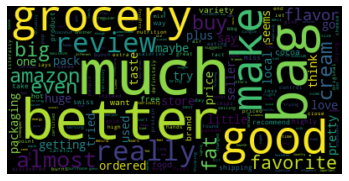

WordCloud for Cluster : clust2  


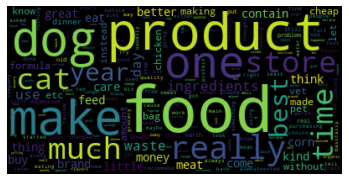

WordCloud for Cluster : clust3  


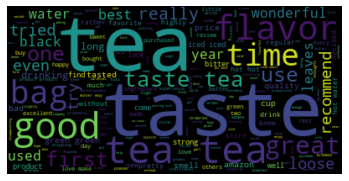

WordCloud for Cluster : clust4  


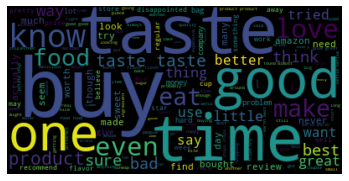

WordCloud for Cluster : clust5  


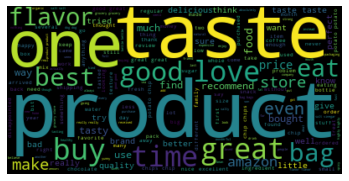

WordCloud for Cluster : clust6  


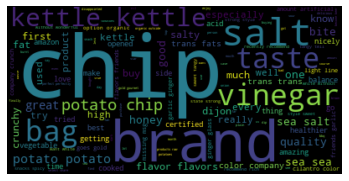

In [312]:
from  wordcloud  import WordCloud

for i in range(0,len(cluster_data)):
    if cluster_data['clust{0}'.format(i)] != []:
        print("WordCloud for Cluster : clust{0}  ".format(i))
        text=' '.join([str(elem) for elem in cluster_data['clust{0}'.format(i)]])
        pos_rev=WordCloud().generate(text)
        plt.imshow(pos_rev,interpolation='bilinear')
        plt.axis("off")
        plt.show()
        

<li>We can observe from wordclouds that words per cluster are much imilar </li>
<li>We can also observe that some features are included into different clusters this displays that these clusters are nearer to each other.</li>

## [5.2] Applying K-means on TFIDF,<font color='red'> SET 2</font>

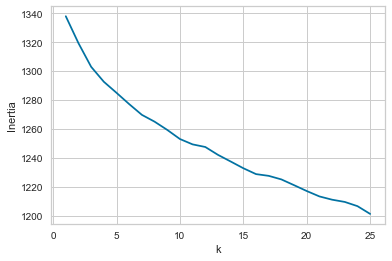

In [313]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


n_clusters=[i for i in range(1,26)]
#n_clusters=[1,2]
inertia=[]
#K-Means Model
for k in n_clusters:
    k_means_clstr=KMeans(n_clusters=k,init='k-means++')
    k_means_clstr.fit(x_train_tf_idf)
    inertia.append(k_means_clstr.inertia_)



plt.plot(n_clusters,inertia,label='K vs Inertia')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()


In [314]:
opt_k_tf_idf=15
k_means_tf_idf=KMeans(n_clusters=opt_k_tf_idf,init='k-means++')
k_means_tf_idf.fit(x_train_tf_idf)
#print(k_means_bow.labels_)

#print(cluster_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<h4>WordCloud per cluster</h4>

In [315]:
cluster_data_tf_idf={}
for i in range(0,opt_k_tf_idf):    
    cluster_data_tf_idf['clust{0}'.format(i)]=[]
#print(cluster_data)
#Words extraction per cluster
for i in range(0,len(k_means_tf_idf.labels_)):              
    features=np.take(tf_idf_vect.get_feature_names(),x_train_tf_idf[i].indices).tolist()
    cluster_data_tf_idf['clust{0}'.format(k_means_tf_idf.labels_[i])] =  cluster_data_tf_idf['clust{0}'.format(k_means_tf_idf.labels_[i])]+features
#print(len(k_means_tf_idf.labels_))

WordCloud for Cluster : clust0  


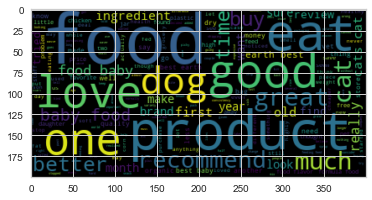

WordCloud for Cluster : clust1  


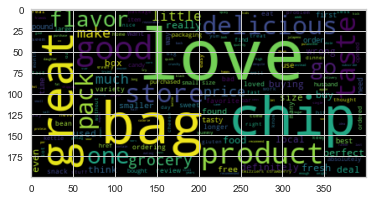

WordCloud for Cluster : clust2  


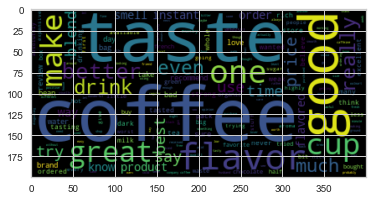

WordCloud for Cluster : clust3  


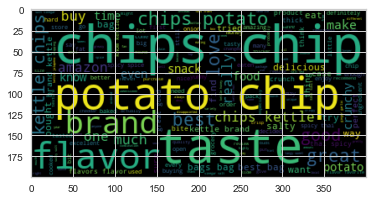

WordCloud for Cluster : clust4  


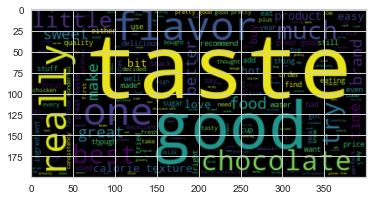

WordCloud for Cluster : clust5  


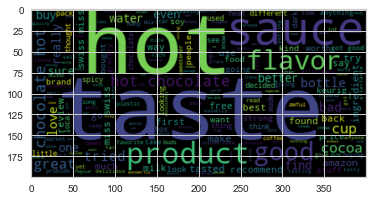

WordCloud for Cluster : clust6  


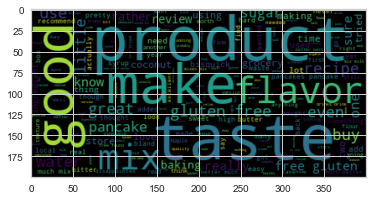

WordCloud for Cluster : clust7  


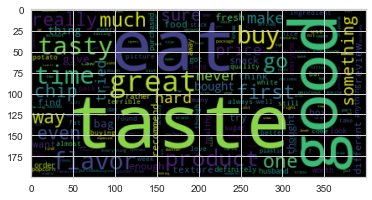

WordCloud for Cluster : clust8  


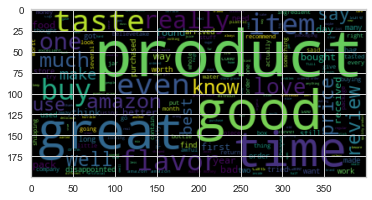

WordCloud for Cluster : clust9  


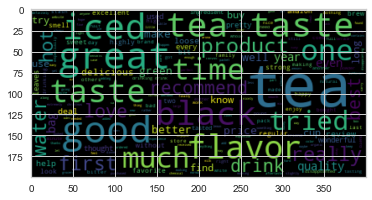

WordCloud for Cluster : clust10  


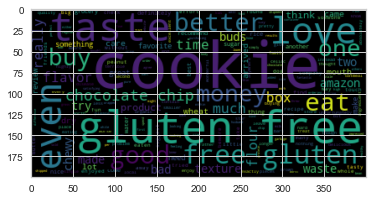

WordCloud for Cluster : clust11  


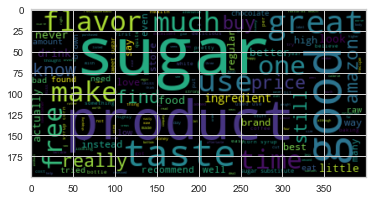

WordCloud for Cluster : clust12  


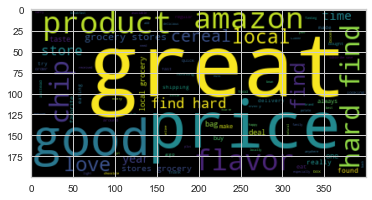

WordCloud for Cluster : clust13  


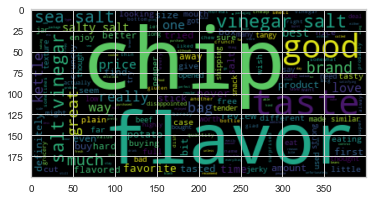

WordCloud for Cluster : clust14  


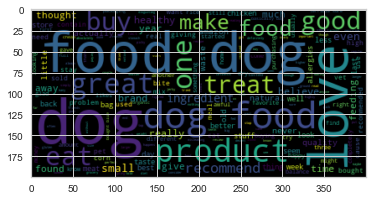

In [316]:
for i in range(0,len(cluster_data_tf_idf)):
    #print(cluster_data_tf_idf['clust{0}'.format(i)])
    if cluster_data_tf_idf['clust{0}'.format(i)] != []:
        print("WordCloud for Cluster : clust{0}  ".format(i))
        text=' '.join([str(elem) for elem in cluster_data_tf_idf['clust{0}'.format(i)]])
        pos_rev=WordCloud().generate(text)
        plt.imshow(pos_rev,interpolation='bilinear')        
        plt.show()
        


<li>We got the optimal k value from knee method is 15</li>
<li>for tf_idf vectorizer k-means developed wie range of clusters to group the data than BOW vectorized datpoints</li>
<li>We can observe from wordclouds that words per cluster are much imilar </li>
<li>We can also observe that some features are included into different clusters this displays that these clusters are nearer to each other.</li>

<h3>Avg Weighted W2V on k-Means</h3>

In [317]:
i=0
list_of_sentance=[]
for sentance in tqdm(preprocessed_reviews):
    list_of_sentance.append(sentance.split())
print(list_of_sentance[1:2])
print('\n')
#print(type(preprocessed_reviews))

100%|██████████████████████████████████████████████████████████████████████████| 1991/1991 [00:00<00:00, 142307.00it/s]


[['received', 'shipment', 'could', 'hardly', 'wait', 'try', 'product', 'love', 'slickers', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'use', 'car', 'windows', 'printed', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'product', 'windows', 'everywhere', 'surfaces', 'like', 'tv', 'screens', 'computer', 'monitors', 'wow', 'make', 'islickers']]




In [318]:
print(list_of_sentance[0:1])
X_train_Avg_W2V_sent, X_test_Avg_W2V_sent, y_train, y_test = train_test_split(list_of_sentance, y, test_size=0.3)
#X_train_Avg_W2V_sent, CV_Avg_W2V_sent, y_train, y_CV = train_test_split(X_1, y_t, test_size=0.3)
#print(X_train_Avg_W2V_sent[0:1])


[['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'decals', 'car', 'window', 'everybody', 'asks', 'bought', 'decals', 'made', 'two', 'thumbs', 'great', 'product']]


In [319]:
w2v_model=Word2Vec(X_train_Avg_W2V_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  1961
sample words  ['come', 'amazon', 'give', 'break', 'powdered', 'get', 'real', 'food', 'buy', 'went', 'looking', 'table', 'sugar', 'got', 'weird', 'kinds', 'expect', 'bulk', 'no', 'plain', 'not', 'rice', 'bread', 'either', 'sorry', 'choice', 'peanut', 'lover', 'much', 'larger', 'peanuts', 'six', 'people', 'christmas', 'gift', 'list', 'ask', 'every', 'year', 'best', 'item', 'shipped', 'plastic', 'bag', 'within', 'brown', 'cardboard', 'shipping', 'arrived', 'product']


In [320]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import  tqdm
X_train_Avg_W2V = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train_Avg_W2V_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero's with length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_Avg_W2V.append(sent_vec)
#print(len(X_train_Avg_W2V))
#print(len(X_train_Avg_W2V[0]))
#print(X_train_Avg_W2V[0:1])

100%|█████████████████████████████████████████████████████████████████████████████| 1393/1393 [00:01<00:00, 946.23it/s]


In [321]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import  tqdm
X_test_Avg_W2V = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test_Avg_W2V_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero's with length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_Avg_W2V.append(sent_vec)
#print(len(X_test_Avg_W2V))
#print(len(X_test_Avg_W2V[0]))
#print(X_test_Avg_W2V[0:1])

100%|███████████████████████████████████████████████████████████████████████████████| 598/598 [00:00<00:00, 965.07it/s]


In [322]:
from sklearn.preprocessing import StandardScaler


SS=StandardScaler(with_mean=False).fit(X_train_Avg_W2V)
x_train_Avg_W2V=SS.transform(X_train_Avg_W2V)
#X_CV_Avg_W2V= SS.transform(CV_Avg_W2V)
x_test_Avg_W2V=SS.transform(X_test_Avg_W2V)
#print(X_train_Avg_W2V[0:1])
#print("\n",len(X_train_Avg_W2V))


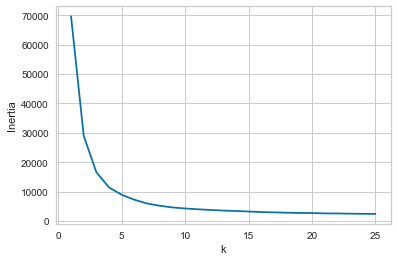

In [323]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


n_clusters=[i for i in range(1,26)]
#n_clusters=[1,2]
inertia=[]
#K-Means Model
for k in n_clusters:
    k_means_clstr=KMeans(n_clusters=k,init='k-means++')
    k_means_clstr.fit(x_train_Avg_W2V)
    inertia.append(k_means_clstr.inertia_)



plt.plot(n_clusters,inertia,label='K vs Inertia')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [324]:
opt_k_Avg_W2V=5
k_means_Avg_W2V=KMeans(n_clusters=opt_k_Avg_W2V,init='k-means++')
k_means_Avg_W2V.fit(x_train_Avg_W2V)
#print(k_means_bow.labels_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<h3>WordCloud for Avg_W2V vectors</h3>

In [325]:
cluster_data_Avg_W2V={}
for i in range(0,opt_k_Avg_W2V):    
    cluster_data_Avg_W2V['clust{0}'.format(i)]=[]
#print(cluster_data)
#Words extraction per cluster
for i in range(0,len(k_means_Avg_W2V.labels_)):        
    #features=np.take(tf_idf_vect.get_feature_names(),X_train_Avg_W2V_sent[i].indices).tolist()
    cluster_data_Avg_W2V['clust{0}'.format(k_means_Avg_W2V.labels_[i])] =  cluster_data_Avg_W2V['clust{0}'.format(k_means_Avg_W2V.labels_[i])]+X_train_Avg_W2V_sent[i]


WordCloud for Cluster : clust0  


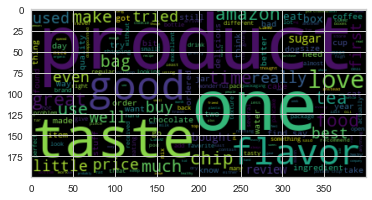

WordCloud for Cluster : clust1  


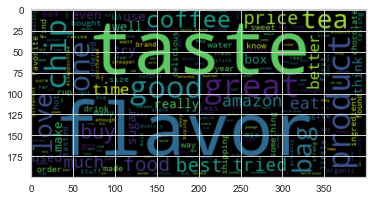

WordCloud for Cluster : clust2  


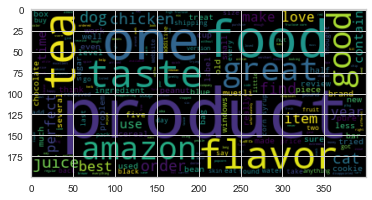

WordCloud for Cluster : clust3  


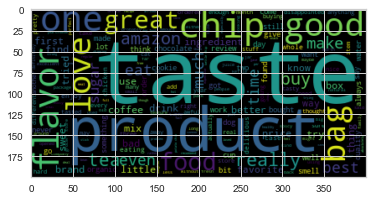

WordCloud for Cluster : clust4  


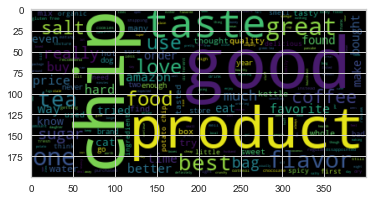

In [326]:
for i in range(0,len(cluster_data_Avg_W2V)):
    if cluster_data_Avg_W2V['clust{0}'.format(i)] != []:
        print("WordCloud for Cluster : clust{0}  ".format(i))
        text=' '.join([str(elem) for elem in cluster_data_Avg_W2V['clust{0}'.format(i)]])
        pos_rev=WordCloud().generate(text)
        plt.imshow(pos_rev,interpolation='bilinear')        
        plt.show()


<li>We got the optimal k value from knee method is 5</li>
<li>Avg W2V vectorizer group data with less number of clusters than tf_idf</li>
<li>We can observe from wordclouds that words per cluster are much similar </li>
<li>We can also observe that some features are included into different clusters this displays that these clusters are nearer to each other.</li>

<h3>TF_IDF W2V on K-Means</h3>

In [327]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, y, test_size=0.3)
#X_train, CV, y_train, y_CV = train_test_split(X_1, y_t, test_size=0.3)# Please write all the code with proper documentation

In [328]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
print(list_of_sentance_train[1:2])



[['fed', 'golden', 'retriever', 'hated', 'would', 'not', 'eat', 'gave', 'terrible', 'diarrhea', 'not', 'buying', 'also', 'super', 'expensive', 'bad']]


In [329]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
print(list_of_sentance_test[1:2])

[['bought', 'brand', 'horrible', 'amazon', 'needs', 'source', 'offer', 'ladies', 'brand', 'wrappers', 'superior', 'anything', 'market', 'today', 'amazon', 'please', 'offer', 'ladies', 'brand', 'rice', 'paper']]


In [330]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_train)
tf_idf_matrix = model.transform(X_train)

# we are converting a dictionary with word as a key, and the idf as a value


dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [331]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_tf_idf_W2V = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tf_idf_W2V.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 1393/1393 [00:06<00:00, 220.38it/s]


In [332]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_test_tf_idf_W2V = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tf_idf_W2V.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████████| 598/598 [00:03<00:00, 166.30it/s]


In [333]:
from sklearn.preprocessing import StandardScaler

SS=StandardScaler(with_mean=False).fit(X_train_tf_idf_W2V)
x_train_tf_idf_W2V = SS.transform(X_train_tf_idf_W2V)
#X_CV_tf_idf_W2V= SS.transform(CV_tf_idf_W2V)
x_test_tf_idf_W2V=SS.transform(X_test_tf_idf_W2V)

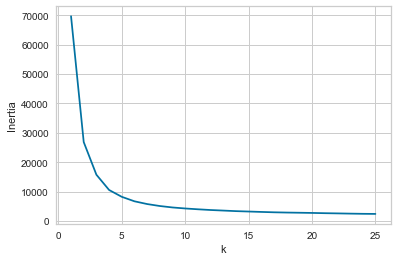

In [334]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


n_clusters=[i for i in range(1,26)]
#n_clusters=[1,2]
inertia_tf_idf_W2V=[]
#K-Means Model
for k in n_clusters:
    k_means_clstr=KMeans(n_clusters=k,init='k-means++')
    k_means_clstr.fit(x_train_tf_idf_W2V)
    inertia_tf_idf_W2V.append(k_means_clstr.inertia_)



plt.plot(n_clusters,inertia_tf_idf_W2V,label='K vs Inertia')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [335]:
opt_k_tf_idf_W2V=5
k_means_tf_idf_W2V=KMeans(n_clusters=opt_k_tf_idf_W2V,init='k-means++')
k_means_tf_idf_W2V.fit(x_train_tf_idf_W2V)
#print(k_means_bow.labels_)

#print(cluster_data)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [336]:
len(list_of_sentance_train)

1393

<h3>WordCloud on Tf_IDF_W2V for Kmeans clustering</h3>

In [337]:
cluster_data_tf_idf_W2V={}
for i in range(0,opt_k_tf_idf_W2V):    
    cluster_data_tf_idf_W2V['clust{0}'.format(i)]=[]
#print(cluster_data)
#Words extraction per cluster
for i in range(0,len(k_means_tf_idf_W2V.labels_)):        
    #features=np.take(tf_idf_vect.get_feature_names(),x_train_tf_idf[i].indices).tolist()
    cluster_data_tf_idf_W2V['clust{0}'.format(k_means_tf_idf_W2V.labels_[i])] =  cluster_data_tf_idf_W2V['clust{0}'.format(k_means_tf_idf_W2V.labels_[i])]+list_of_sentance_train[i]


WordCloud for Cluster : clust0  


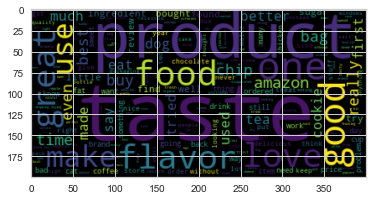

WordCloud for Cluster : clust1  


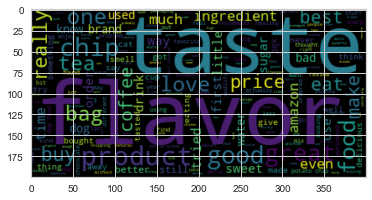

WordCloud for Cluster : clust2  


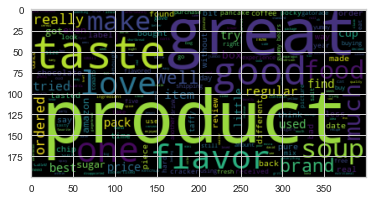

WordCloud for Cluster : clust3  


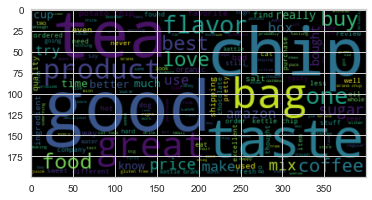

WordCloud for Cluster : clust4  


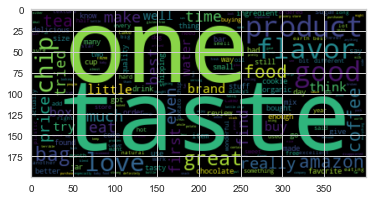

In [338]:
for i in range(0,len(cluster_data_tf_idf_W2V)):
    if cluster_data_tf_idf_W2V['clust{0}'.format(i)] != []:
        print("WordCloud for Cluster : clust{0}  ".format(i))
        text=' '.join([str(elem) for elem in cluster_data_tf_idf_W2V['clust{0}'.format(i)]])
        pos_rev=WordCloud().generate(text)
        plt.imshow(pos_rev,interpolation='bilinear')        
        plt.show()
        


<li>We got the optimal k value from knee method is 5</li>
<li>tf_idf W2V vectorizer group data with less number of clusters than tf_idf</li>
<li>We can observe from wordclouds that words per cluster are much similar </li>
<li>We can also observe that some features are included into different clusters this displays that these clusters are nearer to each other.</li>

<h3> Agglomerative Clustering </h3>

<h3>Avg_W2V on Agglomerative Clustering</h3>

In [339]:
from sklearn.cluster import AgglomerativeClustering
n_cluster_agg=[2,5]

#cluster labels
cluster_labels_Avg_W2V_agg={}
for i in n_cluster_agg:    
    cluster_labels_Avg_W2V_agg['{0}clust'.format(i)]=[]
for i in n_cluster_agg:
    agg_Avg_W2V=AgglomerativeClustering(n_clusters=i,affinity='euclidean',compute_full_tree=True,linkage='ward')
    cluster_labels_Avg_W2V_agg['{0}clust'.format(i)]=agg_Avg_W2V.fit_predict(x_train_Avg_W2V)
#print(cluster_labels_Avg_W2V_agg)

In [340]:
cluster_data_Avg_W2V_agg={}
#print(cluster_data_Avg_W2V_agg)

for i in n_cluster_agg:
    cluster_data_Avg_W2V_agg['cluster_{0}_data_Avg_W2V'.format(i)]={}    
    for j in range(0,i):    
        cluster_data_Avg_W2V_agg['cluster_{0}_data_Avg_W2V'.format(i)]['clust{0}'.format(j)]=[]
#print(cluster_data_Avg_W2V_agg)

In [341]:

for j in n_cluster_agg:
    for i in range(0,len(cluster_labels_Avg_W2V_agg['{0}clust'.format(j)])):    
        data_old=cluster_data_Avg_W2V_agg['cluster_{0}_data_Avg_W2V'.format(j)]['clust{0}'.format(cluster_labels_Avg_W2V_agg['{0}clust'.format(j)][i])]
        cluster_data_Avg_W2V_agg['cluster_{0}_data_Avg_W2V'.format(j)]['clust{0}'.format(i)] = data_old+X_train_Avg_W2V_sent[i]

        
        

WordCloud for 2 Cluster : clust0  


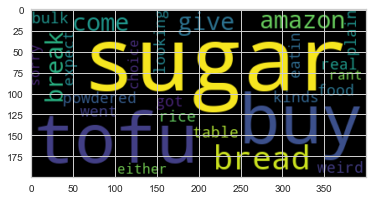

WordCloud for 2 Cluster : clust1  


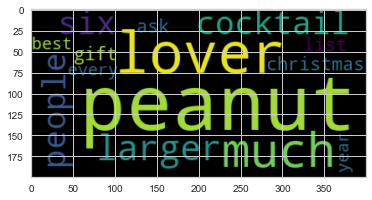

WordCloud for 5 Cluster : clust0  


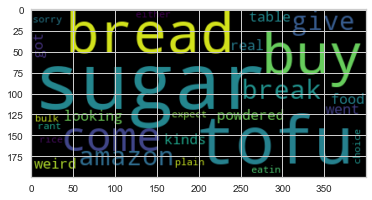

WordCloud for 5 Cluster : clust1  


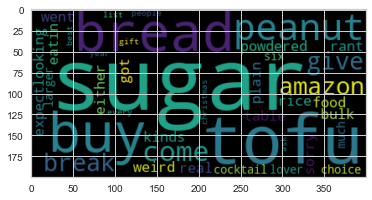

WordCloud for 5 Cluster : clust2  


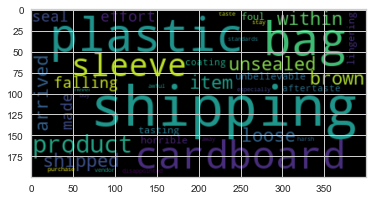

WordCloud for 5 Cluster : clust3  


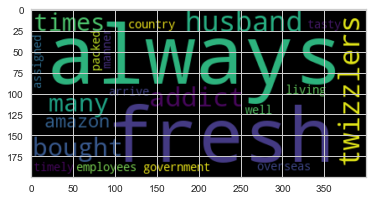

WordCloud for 5 Cluster : clust4  


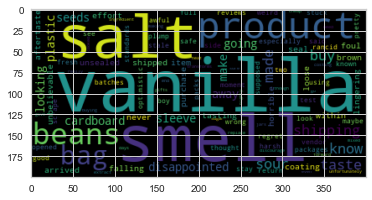

In [342]:
for j in n_cluster_agg:
    for i in range(0,j):
        if cluster_data_Avg_W2V_agg['cluster_{0}_data_Avg_W2V'.format(j)]['clust{0}'.format(i)] != []:
            print("WordCloud for {0} Cluster : clust{1}  ".format(j,i))
            temp_text=cluster_data_Avg_W2V_agg['cluster_{0}_data_Avg_W2V'.format(j)]['clust{0}'.format(i)]
            text=' '.join([str(elem) for elem in temp_text])
            pos_rev = WordCloud().generate(text)
            plt.imshow(pos_rev,interpolation='bilinear')        
            plt.show()
        


<li>Here for two clustered Agglomerative technique the data has been group much accurate than kmeans 2 clustered data.</li>
<li>For two clustered data we can see the words are much unique in wordclouds </li>
<li>We can observe from wordclouds that words per cluster are much similar </li>
<li>We can also observe that some features are included into different clusters this displays that these clusters are nearer to each other.</li>

<h3>Agglomerative using Tf_idf_W2V</h3>

In [343]:
from sklearn.cluster import AgglomerativeClustering
n_cluster_agg=[2,5]

#cluster labels
cluster_labels_tf_idf_W2V_agg={}
for i in n_cluster_agg:    
    cluster_labels_tf_idf_W2V_agg['{0}clust'.format(i)]=[]
for i in n_cluster_agg:
    agg_tf_idf_W2V=AgglomerativeClustering(n_clusters=i,affinity='euclidean',compute_full_tree=True,linkage='ward')
    cluster_labels_tf_idf_W2V_agg['{0}clust'.format(i)]=agg_tf_idf_W2V.fit_predict(x_train_tf_idf_W2V)
#print(cluster_labels_tf_idf_W2V_agg)

In [344]:
cluster_data_tf_idf_W2V_agg={}
#print(cluster_data_Avg_W2V_agg)

for i in n_cluster_agg:
    cluster_data_tf_idf_W2V_agg['cluster_{0}_data_tf_idf_W2V'.format(i)]={}    
    for j in range(0,i):
        #print("s")
        cluster_data_tf_idf_W2V_agg['cluster_{0}_data_tf_idf_W2V'.format(i)]['clust{0}'.format(j)]=[]
#print(cluster_data_Avg_W2V_agg)

In [345]:

for j in n_cluster_agg:
    for i in range(0,len(cluster_labels_tf_idf_W2V_agg['{0}clust'.format(j)])):    
        data_old=cluster_data_tf_idf_W2V_agg['cluster_{0}_data_tf_idf_W2V'.format(j)]['clust{0}'.format(cluster_labels_tf_idf_W2V_agg['{0}clust'.format(j)][i])]
        cluster_data_tf_idf_W2V_agg['cluster_{0}_data_tf_idf_W2V'.format(j)]['clust{0}'.format(i)] = data_old+list_of_sentance_train[i]

        
        

WordCloud for 2 Cluster : clust0  


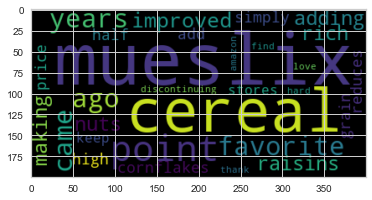

WordCloud for 2 Cluster : clust1  


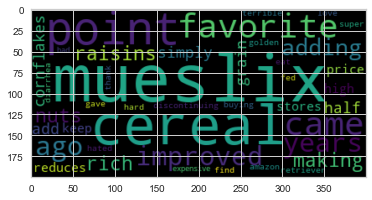

WordCloud for 5 Cluster : clust0  


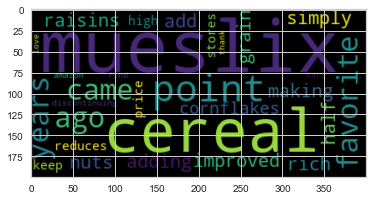

WordCloud for 5 Cluster : clust1  


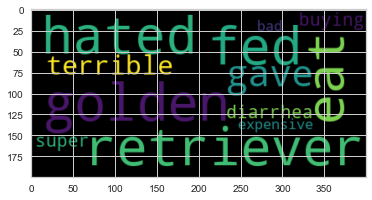

WordCloud for 5 Cluster : clust2  


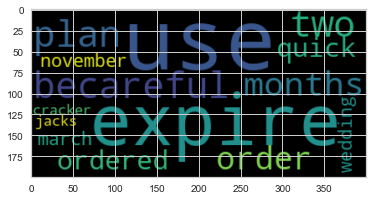

WordCloud for 5 Cluster : clust3  


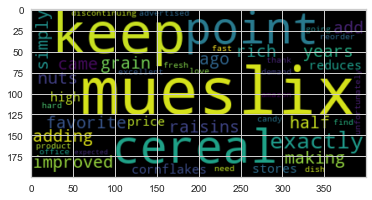

WordCloud for 5 Cluster : clust4  


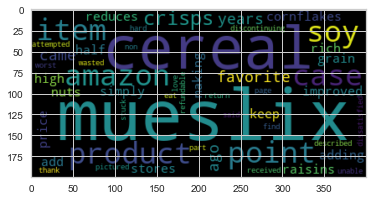

In [346]:
for j in n_cluster_agg:
    for i in range(0,j):
        if cluster_data_tf_idf_W2V_agg['cluster_{0}_data_tf_idf_W2V'.format(j)]['clust{0}'.format(i)] != []:
            print("WordCloud for {0} Cluster : clust{1}  ".format(j,i))
            temp_text=cluster_data_tf_idf_W2V_agg['cluster_{0}_data_tf_idf_W2V'.format(j)]['clust{0}'.format(i)]
            text=' '.join([str(elem) for elem in temp_text])
            pos_rev = WordCloud().generate(text)
            plt.imshow(pos_rev,interpolation='bilinear')        
            plt.show()


<li>Tf_idf W2V vectorizer on Aggolomerative technique behave similar way as Avg W@V implementation</li>
<li>We can observe from wordclouds that words per cluster are much similar </li>
<li>We can also observe that some features are included into different clusters this displays that these clusters are nearer to each other.</li>

<h3>DBSCAN onAvg_W2V</h3>

In [394]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20DBSCAN%20on%20Amazon%20Fine%20Food%20Reviews.ipynb
def n_neighbour(vectors , n):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n])
    return np.sqrt(np.array(distance))

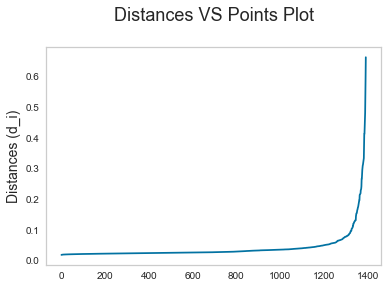

In [395]:

from sklearn.neighbors import NearestNeighbors

min_points = 2*len(X_train_Avg_W2V[0])

# Computing distances of nth-nearest neighbours
nnb = NearestNeighbors(n_neighbors=min_points,algorithm='ball_tree').fit(X_train_Avg_W2V)
distances,indices=nnb.kneighbors(X_train_Avg_W2V)
distance =np.sort(distances)
sorted_distance=[]
for i in distance:
    sorted_distance.append(np.average(i))
# Draw distances(d_i) VS points(x_i) plot
sorted_distances=np.sort(sorted_distance)
plt.plot(sorted_distances)
#plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

In [396]:
cnt_003=0
cnt_005=0
cnt_006=0
cnt_009=0
for i in range(0,len(distances)):
    if np.average(distances[i]) < 0.05:
        cnt_005+=1
    if np.average(distances[i]) < 0.06:
        cnt_006+=1
    if np.average(distances[i]) < 0.09:
        cnt_009+=1
    if np.average(distances[i]) < 0.03:
        cnt_003+=1
print("cnt_003 ",cnt_003)
print("cnt_005 ",cnt_005)
print("cnt_006 ",cnt_006)
print("cnt_009 ",cnt_009)

cnt_003  846
cnt_005  1208
cnt_006  1259
cnt_009  1322


In [397]:
from sklearn.cluster import DBSCAN
#eps=[i*2 for i in range(2,25)]
#for i in eps:
dbscan_Avg_W2V=DBSCAN(eps=2,min_samples=100,metric='euclidean',algorithm='auto')
dbscan_Avg_W2V.fit_predict(x_train_Avg_W2V)

array([ 0,  0,  0, ..., -1,  0,  0], dtype=int64)

In [398]:
set(dbscan_Avg_W2V.labels_)

{-1, 0}

In [399]:
cluster_data_Avg_W2V_dbscn={}
for i in range(0,len(set(dbscan_Avg_W2V.labels_))):
    if i != -1:
        cluster_data_Avg_W2V_dbscn['clust{0}'.format(i)]=[]
#print(cluster_data)
#Words extraction per cluster
for i in range(0,len(dbscan_Avg_W2V.labels_)):        
    if dbscan_Avg_W2V.labels_[i] != -1:
        #features=np.take(tf_idf_vect.get_feature_names(),x_train_tf_idf[i].indices).tolist()
        cluster_data_Avg_W2V_dbscn['clust{0}'.format(dbscan_Avg_W2V.labels_[i])] =  cluster_data_Avg_W2V_dbscn['clust{0}'.format(dbscan_Avg_W2V.labels_[i])]+X_train_Avg_W2V_sent[i]


WordCloud for Cluster : clust0  


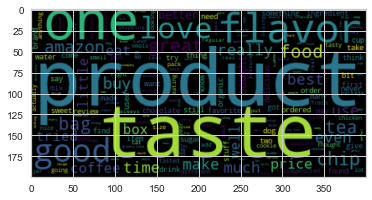

In [400]:
for i in range(0,len(cluster_data_Avg_W2V_dbscn)):
    if cluster_data_Avg_W2V_dbscn['clust{0}'.format(i)] != []:
        print("WordCloud for Cluster : clust{0}  ".format(i))
        text=' '.join([str(elem) for elem in cluster_data_Avg_W2V_dbscn['clust{0}'.format(i)]])
        pos_rev=WordCloud().generate(text)
        plt.imshow(pos_rev,interpolation='bilinear')        
        plt.show()

<li>By elow method we got eps = 0.3 and by brute force way min_samples=100 </li>
<li>Here in DBSCAN most of the smaples are grouped to once cluster and remaining are noise samples</li>


<h3>DBSCAN using Tf_idf_W2V</h3>

In [401]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20DBSCAN%20on%20Amazon%20Fine%20Food%20Reviews.ipynb
def n_neighbour(vectors , n):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n])
    return np.sqrt(np.array(distance))

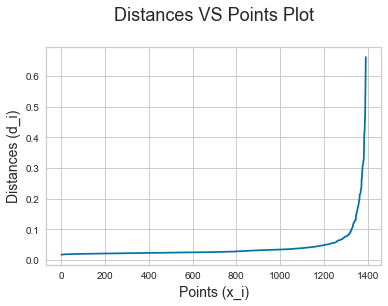

In [402]:

from sklearn.neighbors import NearestNeighbors

min_points = 2*len(X_train_tf_idf_W2V[0])

# Computing distances of nth-nearest neighbours
nnb = NearestNeighbors(n_neighbors=min_points,algorithm='ball_tree').fit(X_train_Avg_W2V)
distances,indices=nnb.kneighbors(X_train_tf_idf_W2V)
sorted_distance = np.sort(distances)
sorted_distance=[]
for i in distance:
    sorted_distance.append(np.average(i))
# Draw distances(d_i) VS points(x_i) plot
sorted_distances=np.sort(sorted_distance)
plt.plot(sorted_distances)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.show()

In [404]:
cnt_003=0
cnt_005=0
cnt_006=0
cnt_009=0
for i in range(0,len(distances)):
    if np.average(distances[i]) < 0.05:
        cnt_005+=1
    if np.average(distances[i]) < 0.06:
        cnt_006+=1
    if np.average(distances[i]) < 0.09:
        cnt_009+=1
    if np.average(distances[i]) < 0.03:
        cnt_003+=1
print("cnt_003 ",cnt_003)
print("cnt_005 ",cnt_005)
print("cnt_006 ",cnt_006)
print("cnt_009 ",cnt_009)

cnt_003  507
cnt_005  943
cnt_006  1020
cnt_009  1116


In [405]:
from sklearn.cluster import DBSCAN
#eps=[i*2 for i in range(2,25)]
#for i in eps:
dbscan_tf_idf_W2V=DBSCAN(eps=2,min_samples=20,metric='euclidean',algorithm='auto')
set(dbscan_tf_idf_W2V.fit_predict(x_train_tf_idf_W2V))

{-1, 0}

In [406]:
cluster_data_tf_idf_W2V_dbscn={}
for i in range(0,len(set(dbscan_tf_idf_W2V.labels_))):  
    if dbscan_tf_idf_W2V.labels_[i] != -1:
        cluster_data_tf_idf_W2V_dbscn['clust{0}'.format(i)]=[]
#print(cluster_data)
#Words extraction per cluster
for i in range(0,len(dbscan_tf_idf_W2V.labels_)):        
    if dbscan_tf_idf_W2V.labels_[i] != -1:
        #features=np.take(tf_idf_vect.get_feature_names(),x_train_tf_idf[i].indices).tolist()
        cluster_data_tf_idf_W2V_dbscn['clust{0}'.format(dbscan_tf_idf_W2V.labels_[i])] =  cluster_data_tf_idf_W2V_dbscn['clust{0}'.format(dbscan_tf_idf_W2V.labels_[i])]+list_of_sentance_train[i]


WordCloud for Cluster : clust0  


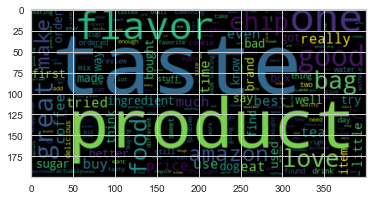

In [407]:
for i in range(0,len(cluster_data_tf_idf_W2V_dbscn)):
    if cluster_data_tf_idf_W2V_dbscn['clust{0}'.format(i)] != []:
        print("WordCloud for Cluster : clust{0}  ".format(i))
        text=' '.join([str(elem) for elem in cluster_data_tf_idf_W2V_dbscn['clust{0}'.format(i)]])
        pos_rev=WordCloud().generate(text)
        plt.imshow(pos_rev,interpolation='bilinear')        
        plt.show()
        

<li>By elow method we got eps = 0.3 and by brute force way min_samples=100 </li>
<li>Here in DBSCAN most of the smaples are grouped to once cluster and remaining are noise samples</li>


# [6] Conclusions

<ul>
    <li>Clustering techniques have much less latency than classification Techniques.</li>
    <li>We can use clustering techniques for dimensionality reduction purpose aswell</li>
    <li>DBCAN behaves well for spectral clusters of data</li>         
</ul>